In [1]:
#source: https://medium.com/@matthew1992/arima-vs-lstm-a-comparative-analysis-of-time-series-forecasting-for-stock-price-prediction-4a765fe0e0ec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# Set up Yahoo Finance data source
yf.pdr_override()

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [16]:
# Retrieve historical stock data
symbol = "AAPL"
start_date = "2024-01-01"
end_date = "2024-07-03"
stock_data = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [17]:
# Extract closing prices
closing_prices = stock_data["Close"]

In [18]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices.values.reshape(-1, 1))

In [19]:
# Divide data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:, :]
test_data_index = closing_prices[train_size:].index

In [20]:
# Function to generate time series dataset for LSTM
def create_dataset(dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        data_x.append(dataset[i:(i + window_size), 0])
        data_y.append(dataset[i + window_size, 0])
    return np.array(data_x), np.array(data_y)

In [21]:
# Generate time series dataset for LSTM
window_size = 5
train_x, train_y = create_dataset(train_data, window_size)
test_x, test_y = create_dataset(test_data, window_size)

In [22]:
# Reshape input to [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

In [23]:
# Construct LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, window_size)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [24]:
# Train LSTM model
model.fit(train_x, train_y, epochs=100, batch_size=1, verbose=0)

In [25]:
# Make predictions with LSTM model
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

1/1 [==============================] - 0s 23ms/step


In [26]:
# Revert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([train_y])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([test_y])

In [27]:
# Compute root mean squared error (RMSE) for LSTM
test_rmse = sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
print("LSTM Test RMSE: ", test_rmse)

LSTM Test RMSE:  5.550680796434178


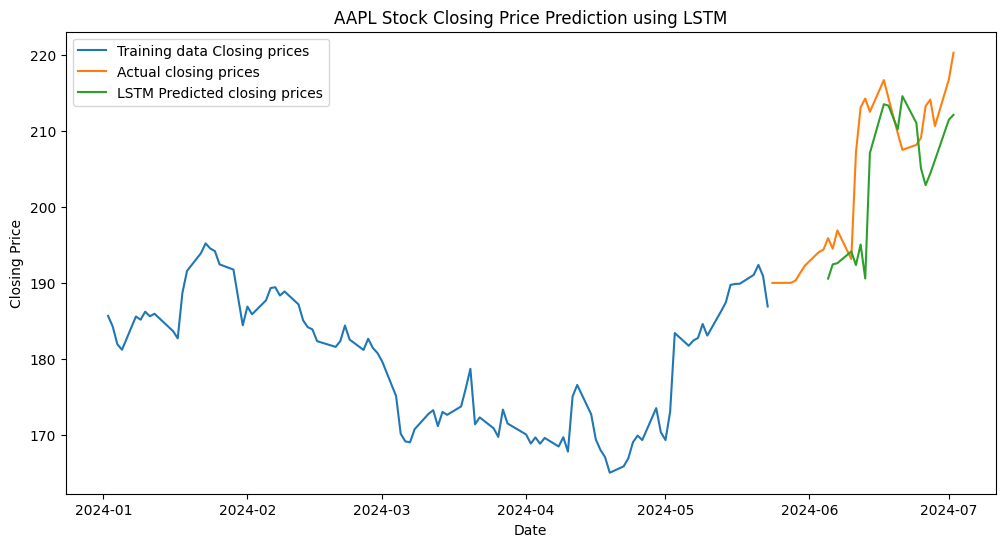

In [28]:
# Display actual vs. predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(closing_prices[:-len(test_data_index)], label="Training data Closing prices")
plt.plot(closing_prices[-len(test_data_index):], label="Actual closing prices")
plt.plot(test_data_index[7:], test_predict[:-1], label="LSTM Predicted closing prices")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(f"{symbol} Stock Closing Price Prediction using LSTM")
plt.legend()
plt.show()